# Breast Cancer Prediction

In this notebook, we will train a neural network using the [Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)) Dataset to discern whether a tumor is malignant or benign. There are many ways to. The Breast Cancer Dataset is an open-source dataset that is very commonly used in Deep Learning starter projects which is the reason why it is chosen for this notebook as it serves as a great dataset to train a neural network with custom training loops

## Imports

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import os
import zipfile
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
from tqdm import tqdm
import tensorflow_datasets as tfds

tf.get_logger().setLevel('ERROR')

## Load and Preprocess the Dataset

First, we will load the dataset and create a data frame using pandas. It’s important to specify the column names explicitly as the CSV file does not contain headers. This step ensures that each feature of the dataset is properly labeled, facilitating easier data manipulation and analysis as we proceed with training our neural network.

In [ ]:


# Step 1: Download the dataset
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/breast-cancer-wisconsin.data'
file_name = 'breast-cancer-wisconsin.data'

# Download the file
urllib.request.urlretrieve(url, file_name)

# Step 2: Load the data into a dataframe
column_names = [
    'id', 'clump_thickness', 'uniformity_of_cell_size', 'uniformity_of_cell_shape',
    'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin',
    'normal_nucleoli', 'mitoses', 'class'
]

df = pd.read_csv(file_name, names=column_names)

In [ ]:
df.head()

,id,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


The first step in our preprocessing pipeline will be to remove the 'id' column from the data frame using the pop method. This column is unnecessary for our analysis and model training since it does not provide any meaningful information related to the prediction of tumor malignancy.



In [ ]:
df.pop("id")

0      1000025
1      1002945
2      1015425
3      1016277
4      1017023
        ...   
694     776715
695     841769
696     888820
697     897471
698     897471
Name: id, Length: 699, dtype: int64

Upon inspecting the dataset, it can be noticed that the bare_nuclei column contains some unknown values. To maintain the integrity of our dataset for model training, these rows will be dropped. Additionally, it's essential to convert the **bare_nuclei** column to a numeric format. This conversion is crucial because numeric data is required for the algorithms we'll use to train the neural network effectively.

In [ ]:
df = df[df["bare_nuclei"] != '?' ]
df.bare_nuclei = pd.to_numeric(df.bare_nuclei)

<ipython-input-5-20cbe26a5d65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.bare_nuclei = pd.to_numeric(df.bare_nuclei)


As part of the data preparation, it's important to check the class distribution within the dataset. We will find two distinct classes represented by the numbers 2.0 and 4.0. For clarity and ease of understanding:

- **2.0** represents benign tumors
- **4.0** denotes malignant tumors


Understanding this distribution is crucial as it helps in assessing the dataset's balance between the different outcomes and informs the setup of our neural network classification tasks.

<Axes: >

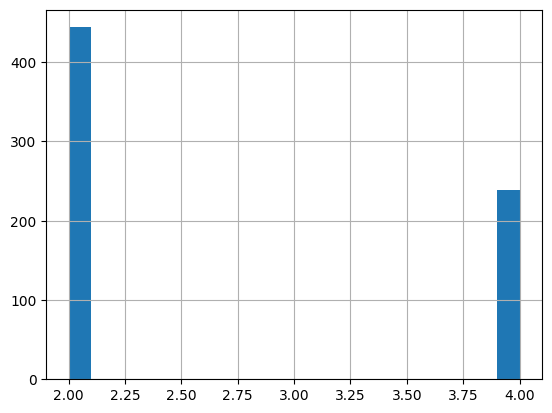

In [ ]:
df['class'].hist(bins=20)

In this tutorial, we will approach the prediction of tumor types as a binary classification problem, focusing on determining the malignancy of the tumor. To prepare our dataset for this task, we need to modify the class labels:

- **benign (2.0)** will be encoded as 0
- **malignant (4.0)** will be encoded as 1

This encoding simplifies the output of our model, enabling it to directly predict whether a tumor is malignant or not based on the numerical label assigned to each class.

In [ ]:
df['class'] = np.where(df['class'] == 2, 0, 1)

Next, we will divide the dataset into training and testing sets. Given the limited number of samples available, we will also utilize the test set to perform validation. This approach helps in efficiently using the data, ensuring that the model is tested under conditions that mimic real-world application as closely as possible, despite the smaller dataset size.

In [ ]:
train, test = train_test_split(df, test_size = 0.2)

# Show the train dataset head
train.head()

,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class
668,5,7,4,1,6,1,7,10,3,1
306,1,1,1,1,2,1,3,1,1,0
303,1,1,1,1,2,1,3,1,1,0
403,3,1,1,1,2,4,1,1,1,0
661,4,1,1,1,2,1,3,1,1,0


As we prepare our data for training, it’s essential to first examine the statistics of the training set. This provides us with a clear picture of the data distribution, which can be critical for understanding any potential biases or skewness in our dataset.

Furthermore, the mean and standard deviation derived from these statistics will be crucial for the next step—normalizing the data. Normalization helps to scale the features into a similar range, which is beneficial for the training process as it can lead to faster convergence and improve the performance of our model.

In [ ]:
train_stats = train.describe()
train_stats.pop('class')
train_stats = train_stats.transpose()

# Print the train_stats head
train_stats.head()

,count,mean,std,min,25%,50%,75%,max
clump_thickness,546.0,4.487179,2.827263,1.0,2.0,4.0,6.0,10.0
uniformity_of_cell_size,546.0,3.133700,3.052819,1.0,1.0,1.0,5.0,10.0
uniformity_of_cell_shape,546.0,3.197802,2.985788,1.0,1.0,1.0,5.0,10.0
marginal_adhesion,546.0,2.802198,2.869849,1.0,1.0,1.0,3.0,10.0
single_epithelial_cell_size,546.0,3.258242,2.249806,1.0,2.0,2.0,4.0,10.0


Next, we will separate the output labels from the input features in our dataset. This involves 'popping' the class column from both the training and test sets. The values removed by this operation will form our train and test outputs, respectively. This step is crucial as it isolates the input features from the target labels, which is a standard practice in preparing data for training machine learning models.

In [ ]:
train_Y = train.pop("class")
test_Y = test.pop("class")

# Print the train_Y head after popping the `class` column
train_Y.head()

668    1
306    0
303    0
403    0
661    0
Name: class, dtype: int64

Here we normalize the data by using the formula: **X = (X - mean(X)) / StandardDeviation(X)**


Here's how to phrase this step in a tutorial-style:

Now, we'll normalize our data to ensure that all input features have a similar scale, which is essential for effective model training. We use the standard normalization formula:

$$ X = \frac{X - \text{mean}(X)}{\text{StandardDeviation}(X)} $$


This formula adjusts each feature in the dataset so that its mean becomes 0 and its standard deviation becomes 1. Normalizing the data in this way helps prevent any one feature from dominating the input to the model due to differences in scale, leading to more stable and faster convergence during training.

In [ ]:
def normalize(x):
    return (x - train_stats['mean']) / train_stats['std']

In [ ]:
norm_train_X = normalize(train)
norm_test_X = normalize(test)

To streamline the process of feeding data into our model, we will now create TensorFlow datasets for both the training and test sets. Using TensorFlow datasets facilitates the efficient management of our input pipeline, allowing for better batching, shuffling, and distribution of data during training and evaluation. This step is fundamental for optimizing the model's learning process and ensuring that our data is properly utilized during training iterations.

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((norm_train_X.values, train_Y.values))
test_dataset = tf.data.Dataset.from_tensor_slices((norm_test_X.values, test_Y.values))

Next, we will shuffle and batch our TensorFlow dataset. Shuffling the data helps prevent the model from learning any inadvertent patterns from the order of the data, enhancing its ability to generalize. After shuffling, we batch the data, which groups several samples together to be processed by the model simultaneously. This batching is not only efficient but also helps in stabilizing the model training by averaging out noise across multiple examples. These prepared batches are then used within our custom training loop, ensuring our model trains effectively and efficiently.

In [ ]:
batch_size = 32
train_dataset = train_dataset.shuffle(buffer_size=len(train)).batch(batch_size)

test_dataset =  test_dataset.batch(batch_size=batch_size)

In [ ]:
a = enumerate(train_dataset)

print(len(list(a)))

18


## Define the Model

Now, let’s define our neural network model using the Keras Functional API. This approach gives us the flexibility to easily customize and experiment with different model architectures. For our task, we will construct a simple network consisting of two Dense layers. Given that we are addressing a binary classification problem—to predict if a tumor is malignant or benign—we will add a final Dense layer with a sigmoid activation function. This layer will output a value between 0 and 1, representing the probability that a given input corresponds to a malignant tumor.


In [ ]:
def base_model():
    inputs = tf.keras.layers.Input(shape=(len(train.columns)))

    x = tf.keras.layers.Dense(128, activation='relu')(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

model = base_model()

## Define Optimizer and Loss

In this model training, we will use RMSProp as our optimizer. RMSProp is an adaptive learning rate method, which means it adjusts the learning rate during training, helping to converge to the minimum loss efficiently. For our loss function, we will employ binary crossentropy. This loss function is particularly suited for binary classification problems like ours, as it measures the distance between the model’s predicted probabilities and the actual binary labels, optimizing the model to make accurate predictions.

In [ ]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## Evaluate Untrained Model

Before we commence training, it's important to evaluate the initial loss of our model. This step involves calculating how well the model performs with its initial weights, which are set randomly. Assessing the loss prior to training provides a baseline measure of model performance, allowing us to see how much the loss decreases as training progresses. This initial evaluation helps in understanding the effectiveness of the training process over time.



In [ ]:
outputs = model(norm_test_X.values).numpy().flatten()

loss_value = loss_object(y_true=test_Y.values, y_pred=outputs)
print("Loss before training %.4f" % loss_value.numpy())

Loss before training 0.6368


After training, we will plot a confusion matrix to visually assess the performance of our model. The confusion matrix is a useful tool for understanding how well the model predicts the different classes. It shows the number of true positives, true negatives, false positives, and false negatives, providing insight into the types of errors the model is making. This visualization helps in identifying patterns in the predictions and can be instrumental in further refining the model for better accuracy.

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title)
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
          plt.text(j, i, format(cm[i, j], fmt),
                  horizontalalignment="center",
                  color="black" if cm[i, j] > thresh else "white")
    plt.show()

<ipython-input-19-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-19-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


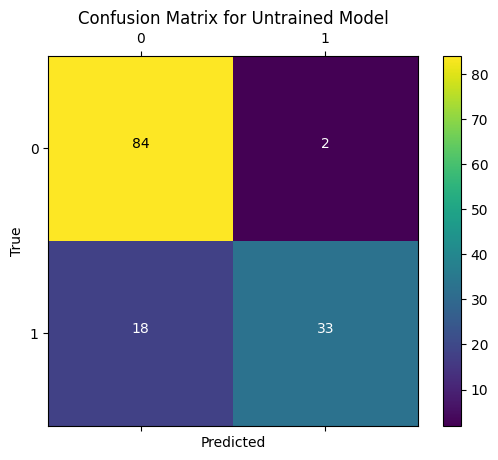

In [ ]:
plot_confusion_matrix(test_Y.values, tf.round(outputs), title='Confusion Matrix for Untrained Model')

## Define Metrics

### Define Custom F1Score Metric

We will define a custom F1Score metric using the formula.

 $$\text{F1 Score} = 2 * \text{(precision * recall)} / \text{(precision + recall)}$$

$$\text{precision} = \text{true_positives} / \text{(true_positives + false_positives)}$$

$$\text{recall} = \text{true_positives} / \text{(true_positives + false_negatives)}$$

We use `confusion_matrix` defined in `tf.math` to calculate precision and recall.

Here we can see that we have subclassed `tf.keras.Metric` and implemented the three required methods `update_state`, `result` and `reset_states`.

In [ ]:
class F1Score(tf.keras.metrics.Metric):

    def __init__(self, name='f1_score', **kwargs):
        '''initializes attributes of the class'''

        # Call the parent class init
        super(F1Score, self).__init__(name=name, **kwargs)

        # Initialize Required variables

        # True positives
        self.tp = tf.Variable(0, dtype = 'int32')
        # False positives
        self.fp = tf.Variable(0, dtype = 'int32')
        # True negatives
        self.tn = tf.Variable(0, dtype = 'int32')
        # False negatives
        self.fn = tf.Variable(0, dtype = 'int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        '''
        Accumulates statistics for the metric

        Args:
            y_true: target values from the test data
            y_pred: predicted values by the model
        '''

        # Calulcate confusion matrix.
        conf_matrix = tf.math.confusion_matrix(y_true, y_pred, num_classes=2)

        # Update values of true positives, true negatives, false positives and false negatives from confusion matrix.
        self.tn.assign_add(conf_matrix[0][0])
        self.tp.assign_add(conf_matrix[1][1])
        self.fp.assign_add(conf_matrix[0][1])
        self.fn.assign_add(conf_matrix[1][0])

    def result(self):
        '''Computes and returns the metric value tensor.'''

        # Calculate precision
        if (self.tp + self.fp == 0):
            precision = 1.0
        else:
            precision = self.tp / (self.tp + self.fp)

        # Calculate recall
        if (self.tp + self.fn == 0):
            recall = 1.0
        else:
            recall = self.tp / (self.tp + self.fn)

        # Calculate f1 score
        f1_score =  2 * ((precision * recall) / (precision + recall))

        return f1_score

    def reset_states(self):
        '''Resets all of the metric state variables.'''

        # The state of the metric will be reset at the start of each epoch.
        self.tp.assign(0)
        self.tn.assign(0)
        self.fp.assign(0)
        self.fn.assign(0)


In [ ]:
# Testing the code

test_F1Score = F1Score()

test_F1Score.tp = tf.Variable(2, dtype = 'int32')
test_F1Score.fp = tf.Variable(5, dtype = 'int32')
test_F1Score.tn = tf.Variable(7, dtype = 'int32')
test_F1Score.fn = tf.Variable(9, dtype = 'int32')
test_F1Score.result()

<tf.Tensor: shape=(), dtype=float64, numpy=0.2222222222222222>

We initialize the seprate metrics required for training and validation. In addition to our custom F1Score metric, we are also using `BinaryAccuracy` defined in `tf.keras.metrics`

In [ ]:
train_f1score_metric = F1Score()
val_f1score_metric = F1Score()

train_acc_metric = tf.keras.metrics.BinaryAccuracy()
val_acc_metric = tf.keras.metrics.BinaryAccuracy()

## Apply Gradients (Please complete this section)

The core of training is using the model to calculate the logits on specific set of inputs and compute the loss(in this case **binary crossentropy**) by comparing the predicted outputs to the true outputs. We then update the trainable weights using the optimizer algorithm chosen. The optimizer algorithm requires our computed loss and partial derivatives of loss with respect to each of the trainable weights to make updates to the same.

We use gradient tape to calculate the gradients and then update the model trainable weights using the optimizer.

### Please complete the following function:

In [ ]:
def apply_gradient(optimizer, loss_object, model, x, y):
    '''
    Applies the gradients to the trainable model weights

    Args:
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        x: input data to the model
        y: target values for each input
    '''

    with tf.GradientTape() as tape:
        logits = model(x)
        loss_value = loss_object(y_true=y, y_pred=logits)

    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    return logits, loss_value

## Training Loop

Next we will define a function that will be used to train our model for one epoch. During each epoch, we process all batches of training data to update the trainable weights. This is achieved using our previously defined functions for calculating gradients and applying updates.

To accurately monitor and evaluate the performance of our model during training, we call the `update_state` method on our metrics after processing each batch. This method accumulates the values of our metrics throughout the epoch, allowing for a comprehensive evaluation of model performance.

Additionally, to enhance user experience and provide a clear visual indication of training progress, we integrate a progress bar using `tqdm`. This tool displays the progress of training in each epoch, giving a dynamic update as each batch is processed.

In [ ]:
def train_data_for_one_epoch(train_dataset, optimizer, loss_object, model,
                             train_acc_metric, train_f1score_metric, verbose=True):
    '''
    Computes the loss then updates the weights and metrics for one epoch.

    Args:
        train_dataset: the training dataset
        optimizer: optimizer to update model weights
        loss_object: type of loss to measure during training
        model: the model we are training
        train_acc_metric: calculates how often predictions match labels
        train_f1score_metric: custom metric we defined earlier
    '''
    losses = []

    # Iterate through all batches of training data
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        # Calculate loss and update trainable variables using optimizer
        logits, loss_value = apply_gradient(optimizer, loss_object, model, x_batch_train, y_batch_train)
        losses.append(loss_value)

        # Round off logits to nearest integer and cast to integer for calulating metrics
        logits = tf.round(logits)
        logits = tf.cast(logits, 'int64')

        # Update the training metrics
        train_acc_metric.update_state(y_batch_train, logits)
        train_f1score_metric.update_state(y_batch_train, logits)

        # Update progress
        if verbose:
            print("Training loss for step %s: %.4f" % (int(step), float(loss_value)))

    return losses

At the conclusion of each training epoch, it's essential to evaluate the model's performance on the test dataset. This step involves calculating the loss on the test data, which helps gauge how well the model generalizes to new, unseen data. To carry out this validation:

1. Calculate Loss: The model's loss on the test dataset is computed to assess its predictive accuracy under validation conditions.
2. Update Validation Metrics: The states of the validation metrics are updated with the new loss values. This is critical for tracking changes and improvements in model performance across different epochs.

This process ensures that we not only optimize the model based on training data but also monitor and enhance its ability to perform effectively on external data, thus maintaining a balance between fitting and generalization.

In [ ]:
def perform_validation():
    losses = []

    # Iterate through all batches of validation data.
    for x_val, y_val in test_dataset:

        # Calculate validation loss for current batch.
        val_logits = model(x_val)
        val_loss = loss_object(y_true=y_val, y_pred=val_logits)
        losses.append(val_loss)

        # Round off and cast outputs to either  or 1
        val_logits = tf.cast(tf.round(model(x_val)), 'int64')

        # Update validation metrics
        val_acc_metric.update_state(y_val, val_logits)
        val_f1score_metric.update_state(y_val, val_logits)

    return losses

In this section, we'll define the comprehensive training loop that systematically progresses through our dataset over a predetermined number of epochs. The loop integrates all the functional components we've developed thus far, executing the following sequence of operations each epoch:

1. Training Over Batches: We process every batch of training data to update the model's trainable weights, utilizing the custom training functions.
2. Metric Evaluation: After training on all batches, we retrieve and record the current values of our training metrics.
3. Validation: We then validate the model on the test dataset to calculate loss and update the validation metrics. This step is essential for assessing the model’s performance on data it hasn’t seen during training.
4. Metric Reset: At the conclusion of each epoch, all metrics are reset to avoid carryover of data from one epoch to the next, ensuring clean and accurate measurements for subsequent epochs.
5. Display Results: We display the statistics for both training and validation at the end of each epoch, providing insight into the model's performance and progress.

**Note:** At the end of each epoch, we calculate and report the cumulative training and validation losses. This gives a comprehensive view of the model's learning trajectory and its efficiency in minimizing error over time.

In [ ]:
# Iterate over epochs.
epochs = 5
epochs_val_losses, epochs_train_losses = [], []

for epoch in range(epochs):
    print('\nStart of epoch %d' % (epoch,))
    # Perform Training over all batches of train data
    losses_train = train_data_for_one_epoch(train_dataset, optimizer, loss_object, model, train_acc_metric, train_f1score_metric)

    # Get results from training metrics
    train_acc = train_acc_metric.result()
    train_f1score = train_f1score_metric.result()

    # Perform validation on all batches of test data
    losses_val = perform_validation()

    # Get results from validation metrics
    val_acc = val_acc_metric.result()
    val_f1score = val_f1score_metric.result()

    # Calculate training and validation losses for current epoch
    losses_train_mean = np.mean(losses_train)
    losses_val_mean = np.mean(losses_val)
    epochs_val_losses.append(losses_val_mean)
    epochs_train_losses.append(losses_train_mean)

    print('Epcoh %s: Train loss: %.4f  Validation Loss: %.4f, Train Accuracy: %.4f, Validation Accuracy %.4f, Train F1 Score: %.4f, Validation F1 Score: %.4f' % (epoch, float(losses_train_mean), float(losses_val_mean), float(train_acc), float(val_acc), train_f1score, val_f1score))

    # Reset states of all metrics
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()
    val_f1score_metric.reset_states()
    train_f1score_metric.reset_states()


Start of epoch 0
Training loss for step 0: 0.6337
Training loss for step 1: 0.5073
Training loss for step 2: 0.4397
Training loss for step 3: 0.4055
Training loss for step 4: 0.3315
Training loss for step 5: 0.3038
Training loss for step 6: 0.3022
Training loss for step 7: 0.2010
Training loss for step 8: 0.2115
Training loss for step 9: 0.1891
Training loss for step 10: 0.1630
Training loss for step 11: 0.2378
Training loss for step 12: 0.1250
Training loss for step 13: 0.1542
Training loss for step 14: 0.1921
Training loss for step 15: 0.1107
Training loss for step 16: 0.1090
Training loss for step 17: 0.1206
Epcoh 0: Train loss: 0.2632  Validation Loss: 0.1223, Train Accuracy: 0.9615, Validation Accuracy 0.9635, Train F1 Score: 0.9446, Validation F1 Score: 0.9505

Start of epoch 1
Training loss for step 0: 0.2191
Training loss for step 1: 0.1612
Training loss for step 2: 0.1281
Training loss for step 3: 0.0548
Training loss for step 4: 0.0707
Training loss for step 5: 0.1052
Traini

## Evaluate the Model

### Plots for Evaluation

To visualize the effectiveness of our model's training process, we plot the progression of loss over the number of epochs. This graph provides valuable insights into how the loss, which reflects the model's error, evolves as training proceeds. Specifically:

- X-axis: The number of epochs, representing the iterations through the entire training dataset.
- Y-axis: The loss value, indicating the magnitude of error between the model's predictions and the actual target values.

By observing the trend of the loss curve, we can assess whether the model is converging towards optimal performance. Ideally, we expect to see a decreasing trend in the loss, indicating that the model is learning and becoming more accurate in its predictions over time.

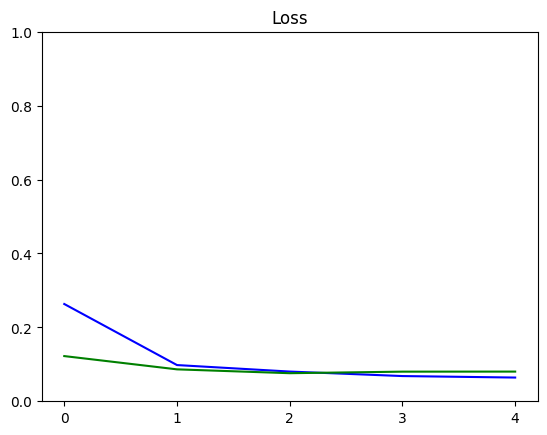

In [ ]:
def plot_metrics(train_metric, val_metric, metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
    plt.plot(train_metric,color='blue',label=metric_name)
    plt.plot(val_metric,color='green',label='val_' + metric_name)

plot_metrics(epochs_train_losses, epochs_val_losses, "Loss", "Loss", ylim=1.0)

We'll also plot a confusion matrix to visually assess the accuracy of our model's predictions. The confusion matrix is a powerful tool for understanding how well a model performs across different classes. Here’s how we use it:

- True Values (Actual Classes): These are plotted on one axis of the matrix, typically the vertical axis.
- Predicted Values: These are plotted on the other axis, typically the horizontal axis.


<br/>Each cell in the matrix represents the number of predictions made by the model for a given actual class against the predicted class. This setup allows us to quickly identify:

- True Positives (TP): Correct predictions where the model accurately predicted the positive class.
- True Negatives (TN): Correct predictions where the model accurately predicted the negative class.
- False Positives (FP): Incorrect predictions where the model incorrectly predicted the positive class.
- False Negatives (FN): Incorrect predictions where the model incorrectly predicted the negative class.


By visualizing these outcomes in a matrix format, we can easily evaluate the model's performance and identify specific areas where it may be confusing one class for another. This visual representation is crucial for diagnosing model behavior and making informed adjustments to improve accuracy.

<ipython-input-19-b043df30f57b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-19-b043df30f57b>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


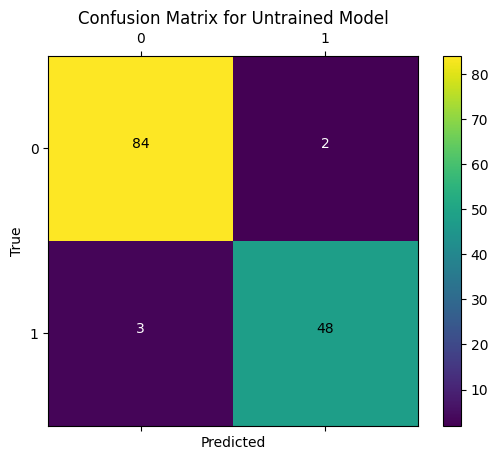

In [ ]:
test_outputs = model(norm_test_X.values)
plot_confusion_matrix(test_Y.values, tf.round(test_outputs), title='Confusion Matrix for Untrained Model')